In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/supplychain/DataCoSupplyChainDataset.xls
/kaggle/input/dataco-smart-supply-chain-for-big-data-analysis/tokenized_access_logs.csv
/kaggle/input/dataco-smart-supply-chain-for-big-data-analysis/DataCoSupplyChainDataset.csv
/kaggle/input/dataco-smart-supply-chain-for-big-data-analysis/DescriptionDataCoSupplyChain.csv


# 0 Read the Data
Data source and desctiption: https://data.mendeley.com/datasets/8gx2fvg2k6/5

This is a dataSet about supply chain from a data service company named DataCo Global. It contains order information in 5 years, which can be used to get some insights of important activities including provisioning, production, sales, commercial distribution. The types of products includes clothing, sports, and electronic supplies.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import ast

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
df_sc = pd.read_csv('../input/dataco-smart-supply-chain-for-big-data-analysis/DataCoSupplyChainDataset.csv', encoding='latin-1')
pd.set_option('display.max_columns', 300)
df_sc.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


# 1 EDA

## 1.1 Data Cleaning
Although there are many columns in this dataset, there are some duplicated columns and some meaningless columns.

In [4]:
#duplicates
print(sum(df_sc['Order Customer Id'] != df_sc['Customer Id']))
print(sum(df_sc['Benefit per order'] != df_sc['Order Profit Per Order']))
print(sum(df_sc['Order Item Product Price'] != df_sc['Product Price']))
print(sum(df_sc['Sales per customer'] != df_sc['Order Item Total']))
print(sum(df_sc['Order Item Cardprod Id'] != df_sc['Product Card Id']))

#all same value
print(sum(df_sc['Product Status'] != 0)) #no stockouts

#missing values: ['Order Zipcode','Product Description']
#useless columns: ['Category Id','Department Id','Customer Email','Customer Fname','Customer Lname','Customer Password','Product Image']

0
0
0
0
0
0


In [5]:
drop_cols = ['Order Zipcode','Product Description'] + \
['Category Id','Department Id','Customer Email','Customer Fname','Customer Lname','Customer Password','Product Image'] + \
['Order Customer Id','Order Profit Per Order','Order Item Product Price','Order Item Total','Order Item Cardprod Id'] + \
['Product Status']

df = df_sc.drop(columns=drop_cols)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Name                  180519 non-null  object 
 8   Customer City                  180519 non-null  object 
 9   Customer Country               180519 non-null  object 
 10  Customer Id                    180519 non-null  int64  
 11  Customer Segment               180519 non-null  object 
 12  Customer State                

## 1.2 Check Unique Values for Categorical Variables

In [7]:
CATEGORICAL = [c for c in df.columns if df[c].dtype =='O']
for name in CATEGORICAL:
    print(name, df[name].nunique())

Type 4
Delivery Status 4
Category Name 50
Customer City 563
Customer Country 2
Customer Segment 3
Customer State 46
Customer Street 7458
Department Name 11
Market 5
Order City 3597
Order Country 164
order date (DateOrders) 65752
Order Region 23
Order State 1089
Order Status 9
Product Name 118
shipping date (DateOrders) 63701
Shipping Mode 4


## 1.3 Check Correlations for Numerical Variables

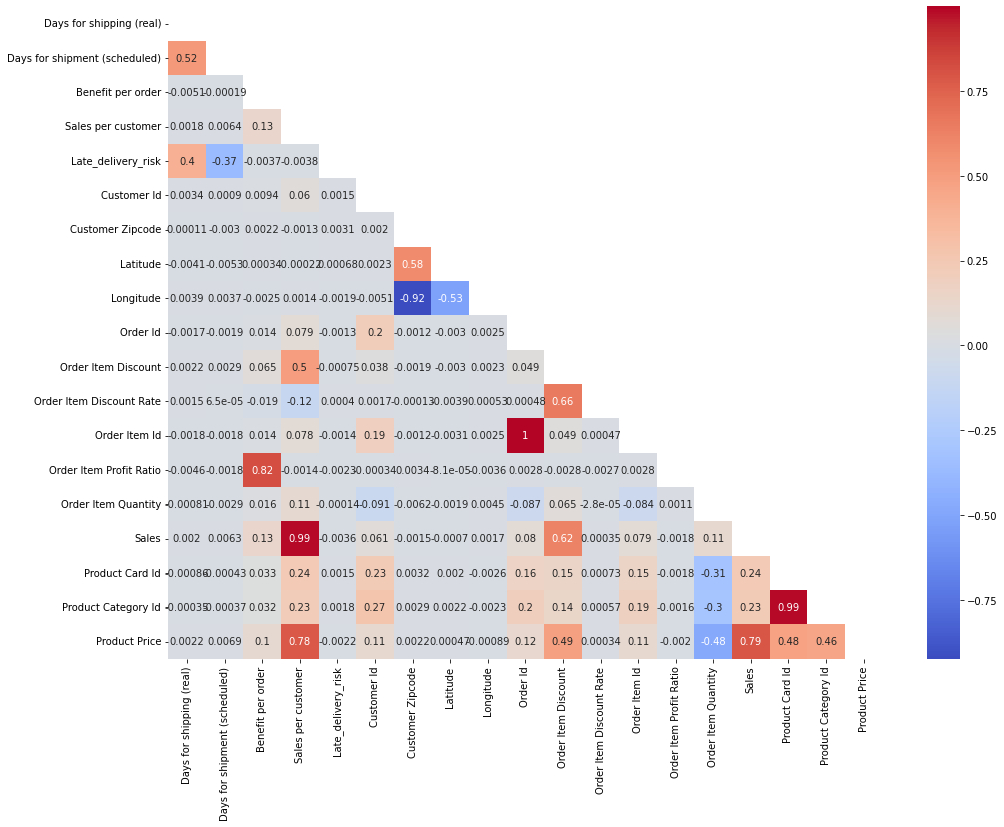

In [8]:
NUMERICAL = [c for c in df.columns if df[c].dtypes != 'O']
fig, ax = plt.subplots(figsize = (16,12))
matrix = np.triu(df[NUMERICAL].corr())
ax = sns.heatmap(df[NUMERICAL].corr(), cmap='coolwarm', annot=True, mask=matrix)
plt.show()

## 1.4 Order Volume, Sales and Late Delivery Risk
In this part, we focus on the sales and late delivery risk in different categories. 
- First, we can get an overview about the sales contributions of different categories.
- Second, we can check the late delivery rate in different categories. A good insight can be: some category have higher late delivery risk than other categories, which means that there may be some points we can optimize.

In [9]:
#plot total number of orders and late delivery rate of each category
def late_delivery_sales_plot(df, col_name, figsize=(6,4), loc=0):
    df_late = df.groupby(col_name)['Late_delivery_risk'].agg(['sum','count'], axis=1)
    df_late['late rate'] = df_late['sum'] / df_late['count']
    
    df_sales = df.groupby(col_name)['Sales'].agg(['sum','count'], axis=1)
    df_sales['sales proportion'] = df_sales['sum'] / sum(df_sales['sum'])
    
    fig, ax = plt.subplots(figsize=figsize)
    bar1 = ax.bar(x=df_late.index, height=df_late['count'], label='Order Volume')
    
    ax2 = ax.twinx()
    line1 = ax2.plot(df_late['late rate'], color='red', marker='*', label='Late Delivery Rate')
    line2 = ax2.plot(df_sales['sales proportion'], color='orange', marker='*', label='Sales Proportion')
        
    # add legend
    plots = [bar1] + line1 + line2
    labels = ['Order Volume', 'Late Delivery Rate', 'Sales Proportion']
    ax.legend(plots, labels, loc=loc)
    
    ax.set_xlabel(col_name)
    ax.set_ylabel('Order Volumn')
    ax2.set_ylabel('Rate')
    
    plt.show()

### 1.4.1 Overall Late Delivery Rate
Overall late delivery rate is 55%, which is pretty high!

In [10]:
df['Late_delivery_risk'].sum() / len(df)

0.5482913155955883

### 1.4.2 Transaction Type
Totally there are 4 transaction types. An interesting point is that DEBIT has the highest order volume and sales proportion, but also has high late delivery risk.

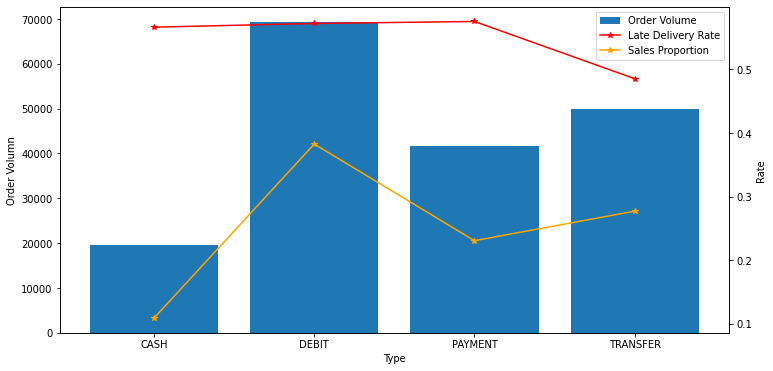

In [11]:
late_delivery_sales_plot(df, 'Type', figsize=(12,6))

### 1.4.3 Customer Country
2 customer countries (Country where the customer made the purchase)
- EE. UU.: United States
- Puerto Rico: a Caribbean island and unincorporated U.S. territory

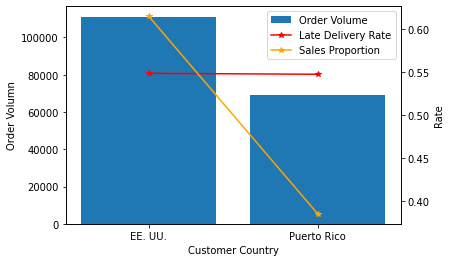

In [12]:
late_delivery_sales_plot(df, 'Customer Country')

### 1.4.4 Customer Segment
- 3 customers segments
- Consumer and Home Office have higher late delivery rate (maybe because the destinations varies a lot)

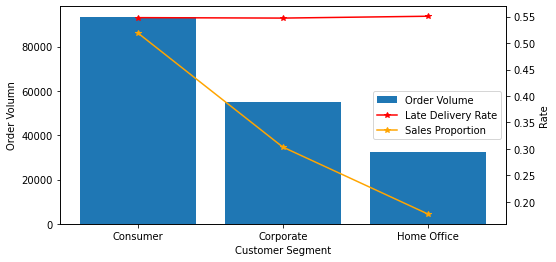

In [13]:
late_delivery_sales_plot(df, 'Customer Segment', figsize=(8,4), loc=7)

### 1.4.5 Department Name

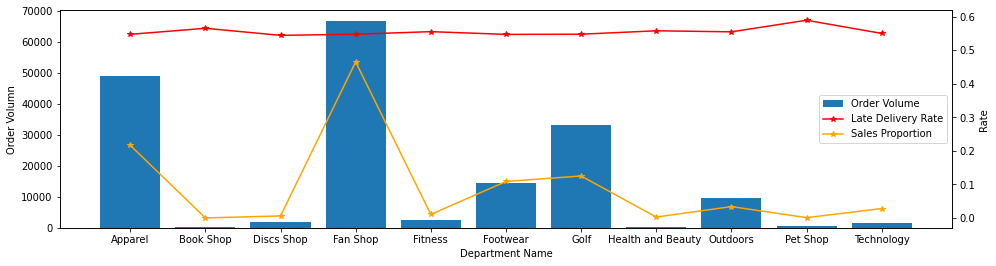

In [14]:
late_delivery_sales_plot(df, 'Department Name', figsize=(16,4), loc=7)

### 1.4.6 Market
Market to where the order is delivered: Africa, Europe, LATAM, Pacific Asia, USCA

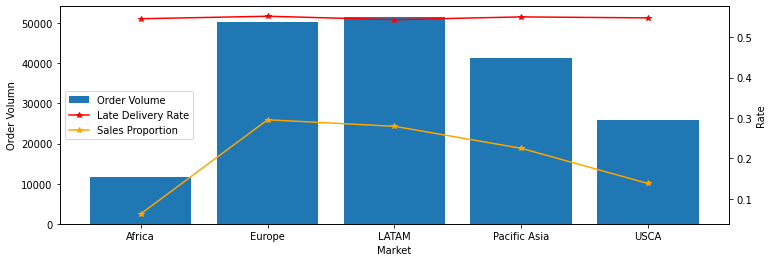

In [15]:
late_delivery_sales_plot(df, 'Market', figsize=(12,4), loc=6)

### 1.4.7 Shipping Mode

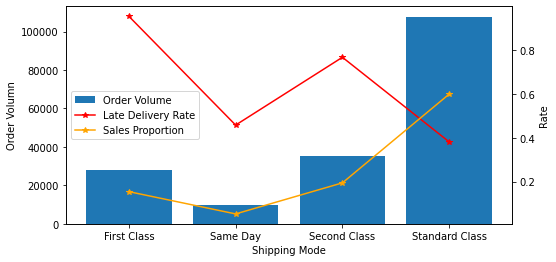

In [16]:
late_delivery_sales_plot(df, 'Shipping Mode', figsize=(8,4), loc=6)

### 1.4.8 Delivery Status / Order Status

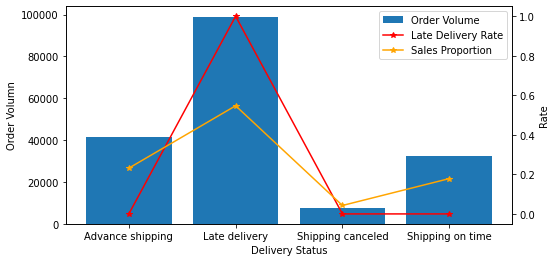

In [17]:
late_delivery_sales_plot(df, 'Delivery Status', figsize=(8,4))

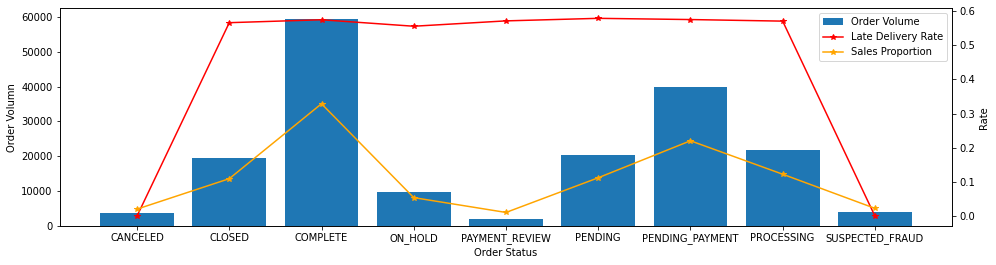

In [18]:
late_delivery_sales_plot(df, 'Order Status', figsize=(16,4))

### 1.4.9 Time Series

In [19]:
df_t = df[['order date (DateOrders)', 'shipping date (DateOrders)', 'Late_delivery_risk', 'Sales']]
df_t['order date (DateOrders)'] = pd.to_datetime(df_t['order date (DateOrders)']).dt.to_period('M')
df_t['shipping date (DateOrders)'] = pd.to_datetime(df_t['shipping date (DateOrders)']).dt.to_period('M')
df_t.head()

,order date (DateOrders),shipping date (DateOrders),Late_delivery_risk,Sales
0,2018-01,2018-02,0,327.75
1,2018-01,2018-01,1,327.75
2,2018-01,2018-01,0,327.75
3,2018-01,2018-01,0,327.75
4,2018-01,2018-01,0,327.75


<AxesSubplot:xlabel='order date (DateOrders)'>

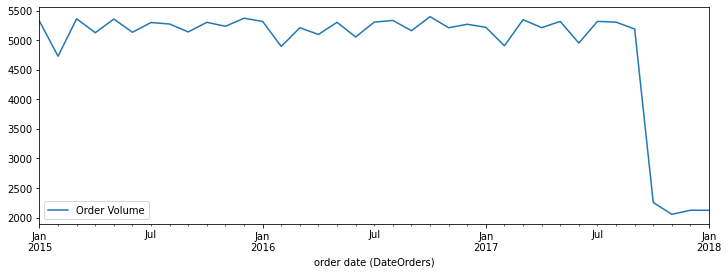

In [20]:
df_t.groupby('order date (DateOrders)').count().reset_index().plot(x='order date (DateOrders)', y='Sales', figsize=(12,4), label='Order Volume')

<AxesSubplot:xlabel='order date (DateOrders)'>

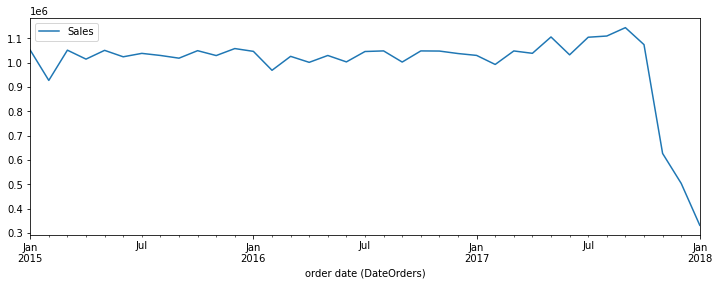

In [21]:
df_t.groupby('order date (DateOrders)').sum().reset_index().plot(x='order date (DateOrders)', y='Sales', figsize=(12,4), label='Sales')

<AxesSubplot:xlabel='order date (DateOrders)'>

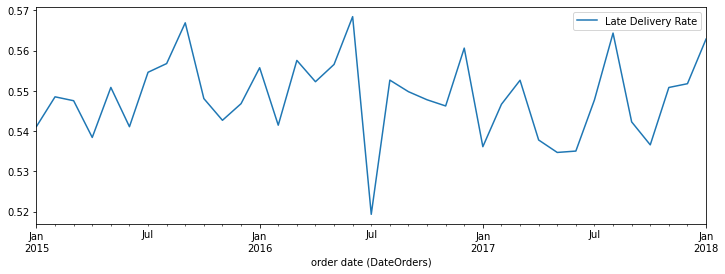

In [22]:
late_t = df_t.groupby('order date (DateOrders)')['Late_delivery_risk'].agg(['sum','count']).reset_index()
late_t['late rate'] = late_t['sum'] / late_t['count']
late_t.plot(x='order date (DateOrders)', y='late rate', figsize=(12,4), label='Late Delivery Rate')

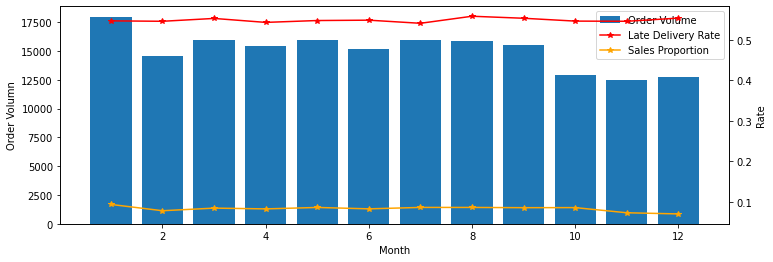

In [23]:
df_t['Month'] = df_t['order date (DateOrders)'].apply(lambda x: x.month)
late_delivery_sales_plot(df_t, 'Month', figsize=(12,4))

# 3 Modelling

## 3.1 Basic Model

In [24]:
feature_list = ['Sales', 'Benefit per order', 'Order Region', 'Order Item Discount Rate', 'Product Price', 'Order Item Quantity', 'Shipping Mode', 'Customer Segment']
X = pd.get_dummies(df[feature_list], drop_first=True)
Y = df['Late_delivery_risk']==1

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

#Logistic Regression model
sc = StandardScaler()
X_train_sd = sc.fit_transform(X_train)
X_val_sd = sc.transform(X_val)
X_test_sd = sc.transform(X_test)

# L1 penalty means lasso; C means alpha: should try multiple values later (do CV)
classifier = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
classifier.fit(X_train_sd, Y_train)
Y_pred  = classifier.predict(X_val_sd)

#Constructing a Confusion Matrix
cm = confusion_matrix(Y_val, Y_pred)
cr = classification_report(Y_val, Y_pred)
print(cm)
print(cr)

[[14423  1888]
 [ 9071 10722]]
              precision    recall  f1-score   support

       False       0.61      0.88      0.72     16311
        True       0.85      0.54      0.66     19793

    accuracy                           0.70     36104
   macro avg       0.73      0.71      0.69     36104
weighted avg       0.74      0.70      0.69     36104



## 3.2 Retrain

In [25]:
#Logistic Regression model
X_train_sd_2 = sc.fit_transform(pd.concat([X_train, X_val]))
Y_train_2 = pd.concat([Y_train, Y_val])
X_test_sd_2 = sc.transform(X_test)

# L1 penalty means lasso; C means alpha
classifier = LogisticRegression(penalty='l1', solver='liblinear', C=1, random_state=0)
classifier.fit(X_train_sd_2, Y_train_2)
Y_pred  = classifier.predict(X_test_sd_2)

#Constructing a Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)
cr = classification_report(Y_test, Y_pred)
print(cm)
print(cr)

[[14360  1947]
 [ 9187 10610]]
              precision    recall  f1-score   support

       False       0.61      0.88      0.72     16307
        True       0.84      0.54      0.66     19797

    accuracy                           0.69     36104
   macro avg       0.73      0.71      0.69     36104
weighted avg       0.74      0.69      0.69     36104



<AxesSubplot:>

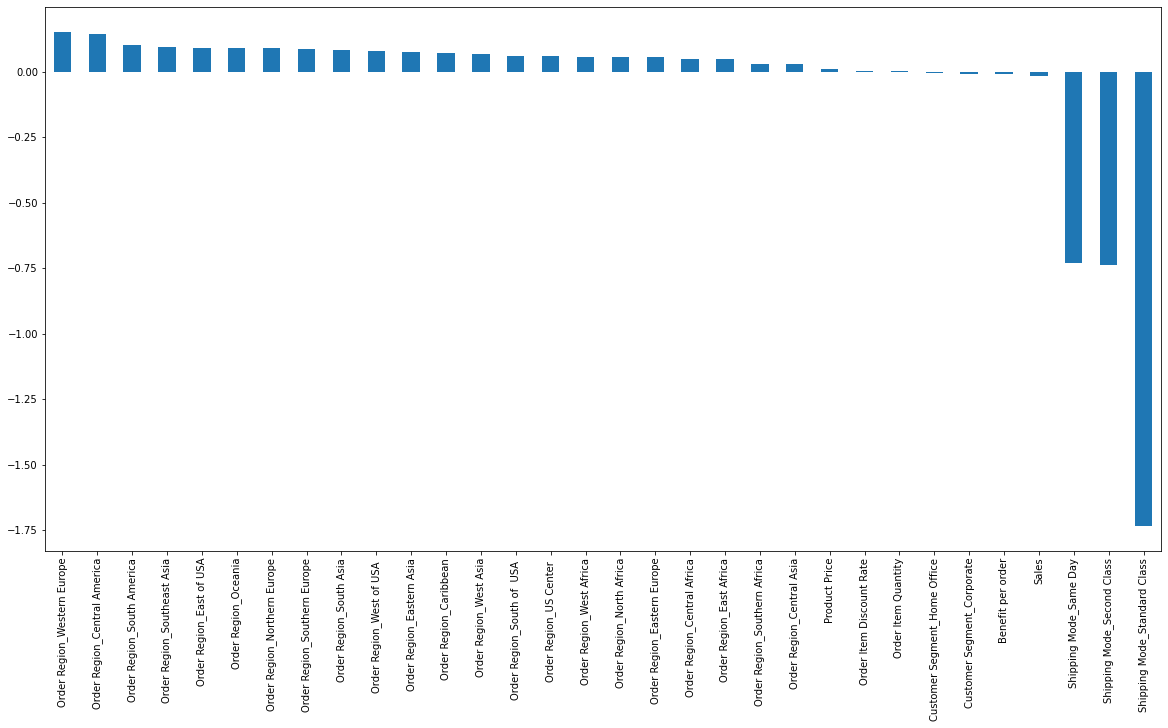

In [26]:
log_coef = pd.Series(classifier.coef_.flatten(), index=list(X.columns))
log_coef.sort_values(ascending=False).plot.bar(figsize=(20, 10))

# 4 Optimization

## 4.1 Optimize the Decision Threshold

Suppose each late delivery has a loss (l). Suppose we can take some actions with a cost (c) to reduce the probability of late delivery.

We can make some assumptions on the values of l and c:
- l: The value can depend on customer retention
    - according to https://clutch.co/logistics/resources/how-two-day-delivery-impacts-small-businesses, 45% of the customers say they are unlikely to continue ordering from a company if it delivers a package late
    - l = 0.45 * profit per order
- c: The value can depend on the specific actions we take.
    - Maybe expend the scheduled delivery time. This will reduce the competitiveness compared to competitors.

Now we wonder when we should take the actions to prevent an order from being late. 
1. predict late probability (p) of orders
2. set a threshold (r)
    - if $p \ge r$ => orders predicted late => take actions
    - if $p<r$ => orders predicted on time => do nothing

expected costs:
- tp = c + (1-s)*l: late actually, late predicted; s is the action's success rate (the probability that the action successfully prevents delay)
- tn = 0: on time actually, on time predicted
- fp = c: on time actually, late predicted
- fn = l: late actually, on time predicted


Divide the orders into 2 segments (because for order with higher profit, we want to be more vigilant):
- High-profit segment: profit per order among the top 20%, use lower threshold
- Low-profit segment: profit per order among the last 80%, use higher threshold

### 4.1.1 Set Parameters
- c: the cost of actions
- s: the effectiveness of the actions

In [27]:
c = 20
s = 0.9

In [28]:
# c = input('Enter cost of actions to prevent delay: ')
# c = int(c) #e.g. 20
# c, type(c)

In [29]:
# s = input('Enter success rate of preventive actions: ')
# s = float(s) #e.g. 0.9
# s, type(s)

In [30]:
classifier.classes_

array([False,  True])

### 4.1.2 Train/Test Split
- Optimize threshold with train set
- Evaluate with test set

In [31]:
r_range = np.arange(0,1.02,0.02)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size =0.2, random_state = 0)
X_train_sd = sc.fit_transform(X_train)

n = X_train.shape[0]
m = X_test.shape[0]
high_profit_ratio = 0.2

train = pd.concat([X_train, Y_train], axis=1)
train.sort_values(by='Benefit per order', ascending=False, inplace=True)
X_train = train.iloc[:,:-1]
Y_train = train.iloc[:,-1]

#training set
X_train_high_profit = X_train.head(int(high_profit_ratio*n))
Y_train_high_profit = Y_train.head(int(high_profit_ratio*n))
X_train_low_profit = X_train.tail(int((1-high_profit_ratio)*n))
Y_train_low_profit = Y_train.tail(int((1-high_profit_ratio)*n))

test = pd.concat([X_test, Y_test], axis=1)
test.sort_values(by='Benefit per order', ascending=False, inplace=True)
X_test = test.iloc[:,:-1]
Y_test = test.iloc[:,-1]

#test set
X_test_high_profit = X_test.head(int(high_profit_ratio*m))
Y_test_high_profit = Y_test.head(int(high_profit_ratio*m))
X_test_low_profit = X_test.tail(int((1-high_profit_ratio)*m))
Y_test_low_profit = Y_test.tail(int((1-high_profit_ratio)*m))

### 4.1.3 Optimize and Evaluate on the Whole Train Set

In [32]:
l_train = 0.45 * X_train['Benefit per order'].clip(lower=0) #for orders with negative profit, set l=0
X_train_sd = sc.fit_transform(X_train)
prob_delay = classifier.predict_proba(X_train_sd)[:,1]
prob_delay

array([0.94991634, 0.7462941 , 0.36066144, ..., 0.43706632, 0.43270785,
       0.81475952])

In [33]:
def calculate_costs(c, s, prob_delay, Y_train, l_train):
    action_cost = [0 for r in r_range]
    current_cost = (np.where(Y_train, 1, 0) * l_train).sum()
    
    for i in range(len(r_range)):
        r = r_range[i]
        Y_pred = np.where(prob_delay > r, 1, 0)

        true_pos = np.where((Y_pred == 1) & (Y_train), 1, 0)
        true_pos_cost = true_pos*c + (1-s) * l_train.values * true_pos

        false_pos = np.where((Y_pred == 1) & (Y_train == False), 1, 0)
        false_pos_cost = false_pos*c

        false_neg = np.where((Y_pred == 0) & (Y_train), 1, 0)
        false_neg_cost = l_train.values * false_neg

        action_cost[i] = true_pos_cost.sum() + false_pos_cost.sum() + false_neg_cost.sum()
    
    return current_cost, action_cost

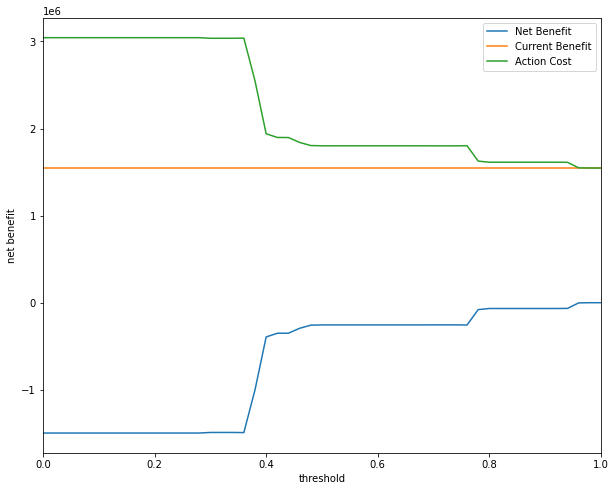

In [34]:
current_cost, action_cost = calculate_costs(c, s, prob_delay, Y_train, l_train)
benefit = current_cost - action_cost

plt.figure(figsize=(10, 8))
# plt.ylim((0, 20000)) 
plt.xlim((0, 1))
plt.ylabel('net benefit')
plt.xlabel('threshold')
plt.plot(r_range, benefit, label='Net Benefit')
plt.plot(r_range, np.repeat(current_cost, len(r_range)), label='Current Benefit')
plt.plot(r_range, action_cost, label='Action Cost')
plt.legend()

### 4.1.4 Optimize and Evaluate on 2 Profit Segments

In [35]:
l_train_high_profit = 0.45 * X_train_high_profit['Benefit per order']
l_train_low_profit = 0.45 * X_train_low_profit['Benefit per order'].clip(lower=0) #for orders with negative profit, set l=0
l_train_high_profit.head()

175116    410.309995
48281     388.800000
82161     324.719989
43944     324.134995
58471     324.000000
Name: Benefit per order, dtype: float64

In [36]:
X_train_high_profit_sd = sc.transform(X_train_high_profit)
X_train_low_profit_sd = sc.transform(X_train_low_profit)

prob_delay_high_profit = classifier.predict_proba(X_train_high_profit_sd)[:,1]
prob_delay_low_profit = classifier.predict_proba(X_train_low_profit_sd)[:,1]

optimal threshold for high profit orders: 0.42


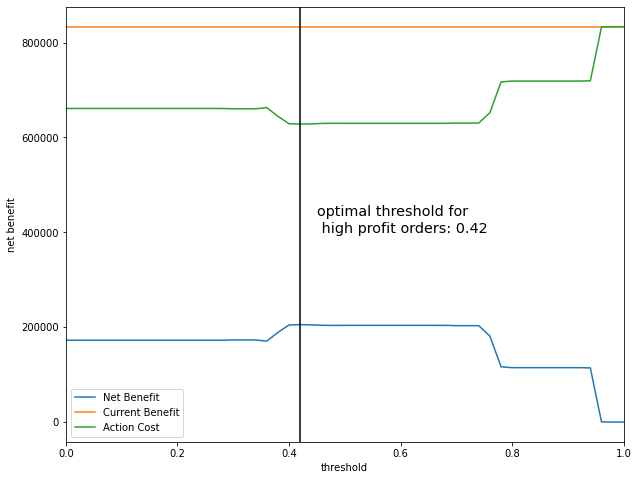

In [37]:
# high profit segment, train for optimal threshold
current_cost_high_profit, action_cost_high_profit = calculate_costs(c, s, prob_delay_high_profit, Y_train_high_profit, l_train_high_profit)
benefit_high_profit = current_cost_high_profit - action_cost_high_profit

optimal_r_high_profit = r_range[np.argmax(benefit_high_profit)]
print("optimal threshold for high profit orders:", optimal_r_high_profit)

plt.figure(figsize=(10, 8))
# plt.ylim((0, 20000))
plt.xlim((0, 1))
plt.ylabel('net benefit')
plt.xlabel('threshold')
plt.plot(r_range, benefit_high_profit, label='Net Benefit')
plt.plot(r_range, np.repeat(current_cost_high_profit, len(r_range)), label='Current Benefit')
plt.plot(r_range, action_cost_high_profit, label='Action Cost')
plt.legend()
plt.axvline(optimal_r_high_profit, color='black')
plt.text(0.45, 400000, 'optimal threshold for \n high profit orders: {}'.format(optimal_r_high_profit), fontsize='x-large')
plt.show()

optimal threshold for low profit orders: 0.98


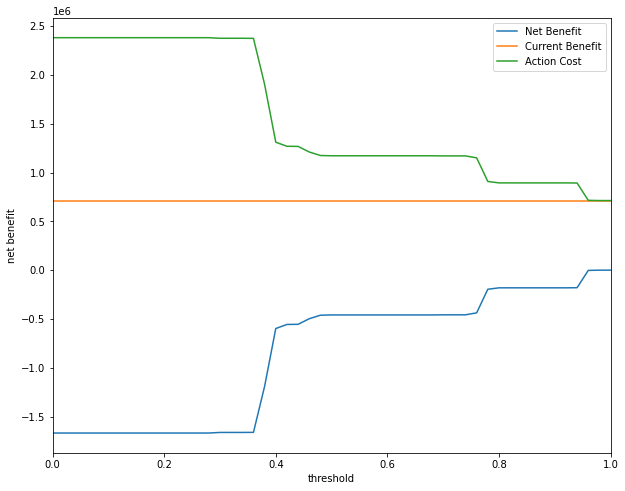

In [38]:
# low profit segment
current_cost_low_profit, action_cost_low_profit = calculate_costs(c, s, prob_delay_low_profit, Y_train_low_profit, l_train_low_profit)
benefit_low_profit = current_cost_low_profit - action_cost_low_profit

optimal_r_low_profit = r_range[np.argmax(benefit_low_profit)]
print("optimal threshold for low profit orders:", optimal_r_low_profit)

plt.figure(figsize=(10, 8))
# plt.ylim((0, 20000))
plt.xlim((0, 1))
plt.ylabel('net benefit')
plt.xlabel('threshold')
plt.plot(r_range, benefit_low_profit, label='Net Benefit')
plt.plot(r_range, np.repeat(current_cost_low_profit, len(r_range)), label='Current Benefit')
plt.plot(r_range, action_cost_low_profit, label='Action Cost')
plt.legend()
plt.show()

In [39]:
# evaluate benefit on test set
l_test_high_profit = 0.45 * X_test_high_profit['Benefit per order']
l_test_low_profit = 0.45 * X_test_low_profit['Benefit per order']

X_test_high_profit_sd = sc.transform(X_test_high_profit)
X_test_low_profit_sd = sc.transform(X_test_low_profit)

prob_delay_test_high_profit = classifier.predict_proba(X_test_high_profit_sd)[:,1]
prob_delay_test_low_profit = classifier.predict_proba(X_test_low_profit_sd)[:,1]

def calculate_costs_test(optimal_r, prob_delay_test, Y_test, l_test):
    current_cost = (np.where(Y_test, 1, 0) * l_test).sum()    
    action_cost = 0
    
    Y_pred = np.where(prob_delay_test > optimal_r, 1, 0)

    true_pos = np.where((Y_pred == 1) & (Y_test), 1, 0)
    true_pos_cost = true_pos*c + (1-s) * l_test.values * true_pos

    false_pos = np.where((Y_pred == 1) & (Y_test == False), 1, 0)
    false_pos_cost = false_pos*c

    false_neg = np.where((Y_pred == 0) & (Y_test), 1, 0)
    false_neg_cost = l_test.values * false_neg
    
    action_cost = true_pos_cost.sum() + false_pos_cost.sum() + false_neg_cost.sum()

    return current_cost, action_cost

# high profit segment
current_cost_test_high_profit, action_cost_test_high_profit = calculate_costs_test(optimal_r_high_profit, prob_delay_test_high_profit, Y_test_high_profit, l_test_high_profit)
benefit_test_high_profit = current_cost_test_high_profit - action_cost_test_high_profit

In [40]:
potential_val = (np.where(Y_test_high_profit, 1, 0) * (-c) + s * l_test_high_profit.values * np.where(Y_test_high_profit, 1, 0) ).sum()

print('Reduces', '{:0.0f}'.format( (benefit_test_high_profit / current_cost_test_high_profit)*100 ), '%', 'of current loss in high profit segment')
print('Captures', '{:0.0f}'.format( (benefit_test_high_profit / potential_val)*100 ), '%', 'of the potential value relative to perfect foresight')
print("Average benefit per high profit order:", "$", '{:0.2f}'.format(benefit_test_high_profit / len(Y_test_high_profit) ) )

Reduces 25 % of current loss in high profit segment
Captures 48 % of the potential value relative to perfect foresight
Average benefit per high profit order: $ 7.04


### 4.1.5 Visualization

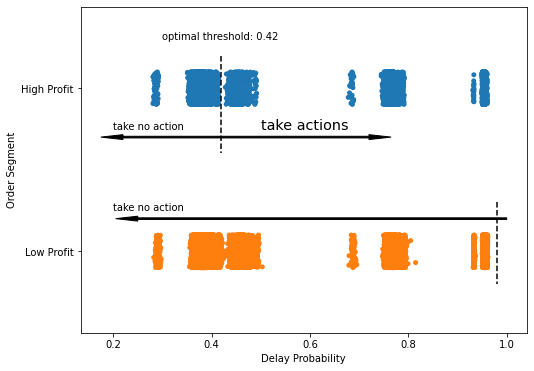

In [41]:
prob_high_profit_df = pd.DataFrame(data=prob_delay_high_profit, columns=['Delay Probability'])
prob_high_profit_df['Order Segment'] = 'High Profit'

prob_low_profit_df = pd.DataFrame(data=prob_delay_low_profit, columns=['Delay Probability'])
prob_low_profit_df['Order Segment'] = 'Low Profit'

prob_df = pd.concat([prob_high_profit_df, prob_low_profit_df], ignore_index=True, axis=0)
prob_df['Risk'] = pd.concat([Y_train_high_profit, Y_train_low_profit], axis=0)


fig, ax = plt.subplots(figsize=(8,6))
ax.vlines(optimal_r_high_profit, -0.2, 0.4, colors='black', linestyles='dashed', zorder=10)
ax.text(0.3, -0.3, 'optimal threshold: {}'.format(optimal_r_high_profit))
ax.text(0.5, 0.25, 'take actions', fontsize='x-large')
ax.arrow(0.42, 0.3, 0.3, 0, width=0.01, color='black')
ax.text(0.2, 0.25, 'take no action')
ax.arrow(0.42, 0.3, -0.2, 0, width=0.01, color='black')

ax.vlines(optimal_r_low_profit, 0.7, 1.2, colors='black', linestyles='dashed', zorder=10)
ax.arrow(1, 0.8, -0.75, 0, width=0.01, color='black')
ax.text(0.2, 0.75, 'take no action')


ax = sns.stripplot(y="Order Segment", x="Delay Probability", data=prob_df, jitter=0.1)

## 4.2 Experiment with Different c and s
conclusions:
- High cost and low success probability will increase the optimal threshold and reduce the benefit.
- In reality, it is very important to control the cost and success probability of the actions. We can decide whether to take actions or not according to the cost and success probability.

In [42]:
#l_train, train_prob_delay
#l_train_high_profit, prob_delay_high_profit
#l_train_low_profit, prob_delay_low_profit
l_train = 0.45 * X_train['Benefit per order'].clip(lower=0) #for orders with negative profit, set l=0
X_train_sd = sc.fit_transform(X_train)
prob_delay_train = classifier.predict_proba(X_train_sd)[:,1]

l_train_high_profit = 0.45 * X_train_high_profit['Benefit per order']
X_train_high_profit_sd = sc.transform(X_train_high_profit)
prob_delay_train_high_profit = classifier.predict_proba(X_train_high_profit_sd)[:,1]

l_train_low_profit = 0.45 * X_train_low_profit['Benefit per order'].clip(lower=0)
X_train_low_profit_sd = sc.transform(X_train_low_profit)
prob_delay_train_low_profit = classifier.predict_proba(X_train_low_profit_sd)[:,1]

#l_test, test_prob_delay
#l_test_high_profit, prob_delay_test_high_profit
#l_test_low_profit, prob_delay_test_low_profit

l_test = 0.45 * X_test['Benefit per order'].clip(lower=0) #for orders with negative profit, set l=0
X_test_sd = sc.fit_transform(X_test)
prob_delay_test = classifier.predict_proba(X_test_sd)[:,1]

l_test_high_profit = 0.45 * X_test_high_profit['Benefit per order']
X_test_high_profit_sd = sc.transform(X_test_high_profit)
prob_delay_test_high_profit = classifier.predict_proba(X_test_high_profit_sd)[:,1]

l_test_low_profit = 0.45 * X_test_low_profit['Benefit per order'].clip(lower=0)
X_test_low_profit_sd = sc.transform(X_test_low_profit)
prob_delay_test_low_profit = classifier.predict_proba(X_test_low_profit_sd)[:,1]

In [43]:
cs = [1, 10, 20, 30]
ss = [0.7, 0.8, 0.9, 0.99]
results = {}
results_high_profit = dict()
results_low_profit = dict()

#whole data
for c in cs:
    for s in ss:
        current_cost_train, action_cost_train = calculate_costs(c, s, prob_delay_train, Y_train, l_train)
        benefit_train = current_cost_train - action_cost_train
        optimal_r = r_range[np.argmax(benefit_train)]
        
        potential_val_test = (np.where(Y_test, 1, 0) * (-c) + s * l_test.values * np.where(Y_test, 1, 0) ).sum()        
        current_cost_test, action_cost_test = calculate_costs_test(optimal_r, prob_delay_test, Y_test, l_test)
        benefit_test = current_cost_test - action_cost_test_high_profit
        
        reduces_test = round(benefit_test_high_profit / current_cost_test_high_profit, 2)
        captures_test = round(benefit_test / potential_val_test, 2)
        avg_benefit_per_order = round(benefit_test / len(Y_test), 2)
        
        results[(c, s)] = (optimal_r, benefit_test, action_cost_test, reduces_test, potential_val_test, captures_test, avg_benefit_per_order)

In [44]:
#high profit segment
for c in cs:
    for s in ss:
        current_cost_train_high_profit, action_cost_train_high_profit = calculate_costs(c, s, prob_delay_train_high_profit, Y_train_high_profit, l_train_high_profit)
        benefit_train_high_profit = current_cost_train_high_profit - action_cost_train_high_profit
        optimal_r_high_profit = r_range[np.argmax(benefit_train_high_profit)]
        
        potential_val_test_high_profit = (np.where(Y_test_high_profit, 1, 0) * (-c) + s * l_test_high_profit.values * np.where(Y_test_high_profit, 1, 0) ).sum()        
        current_cost_test_high_profit, action_cost_test_high_profit = calculate_costs_test(optimal_r_high_profit, prob_delay_test_high_profit, Y_test_high_profit, l_test_high_profit)
        benefit_test_high_profit = current_cost_test_high_profit - action_cost_test_high_profit
        
        reduces_test_high_profit = round(benefit_test_high_profit / current_cost_test_high_profit, 2)
        captures_test_high_profit = round(benefit_test_high_profit / potential_val_test_high_profit, 2)
        avg_benefit_per_order_high_profit= round(benefit_test_high_profit / len(Y_test_high_profit), 2)
        
        results_high_profit[(c, s)] = (optimal_r_high_profit, action_cost_test_high_profit, current_cost_test_high_profit, reduces_test_high_profit, potential_val_test_high_profit, captures_test_high_profit, avg_benefit_per_order_high_profit)

In [45]:
#low profit segment
for c in cs:
    for s in ss:
        current_cost_train_low_profit, action_cost_train_low_profit = calculate_costs(c, s, prob_delay_train_low_profit, Y_train_low_profit, l_train_low_profit)
        benefit_train_low_profit = current_cost_train_low_profit - action_cost_train_low_profit
        optimal_r_low_profit = r_range[np.argmax(benefit_train_low_profit)]
        
        potential_val_test_low_profit = (np.where(Y_test_low_profit, 1, 0) * (-c) + s * l_test_low_profit.values * np.where(Y_test_low_profit, 1, 0) ).sum()        
        current_cost_test_low_profit, action_cost_test_low_profit = calculate_costs_test(optimal_r_low_profit, prob_delay_test_low_profit, Y_test_low_profit, l_test_low_profit)
        benefit_test_low_profit = current_cost_test_low_profit - action_cost_test_low_profit
        
        reduces_test_low_profit = round(benefit_test_low_profit / current_cost_test_low_profit, 2)
        captures_test_low_profit = round(benefit_test_low_profit / potential_val_test_low_profit, 2)
        avg_benefit_per_order_low_profit= round(benefit_test_low_profit / len(Y_test_low_profit), 2)
        
        results_low_profit[(c, s)] = (optimal_r_low_profit, action_cost_test_low_profit, current_cost_test_low_profit, reduces_test_low_profit, potential_val_test_low_profit, captures_test_low_profit, avg_benefit_per_order_low_profit)


In [46]:
#whole data
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Optimal r', 'Action Cost', 'Original Cost', 'Cost Reduction', 'Perfect Reduction', 'Perfect Captures', 'Average Benefit Per Order'])
results_df.index.name = '(c, s)'
results_df

,Optimal r,Action Cost,Original Cost,Cost Reduction,Perfect Reduction,Perfect Captures,Average Benefit Per Order
"(c, s)",,,,,,,
"(1, 0.7)",0.00,231375.924072,151780.256585,0.25,250191.265364,0.92,6.41
"(1, 0.8)",0.00,231375.924072,113221.504390,0.25,288750.017559,0.80,6.41
"(1, 0.9)",0.00,231375.924072,74662.752195,0.25,327308.769754,0.71,6.41
"(1, 0.99)",0.00,231375.924072,39959.875219,0.25,362011.646729,0.64,6.41
"(10, 0.7)",0.52,231375.924072,363902.056217,0.25,72711.265364,3.18,6.41
"(10, 0.8)",0.52,231375.924072,342822.703969,0.25,111270.017559,2.08,6.41
"(10, 0.9)",0.52,231375.924072,321743.351722,0.25,149828.769754,1.54,6.41
"(10, 0.99)",0.52,231375.924072,302771.934699,0.25,184531.646729,1.25,6.41
"(20, 0.7)",0.98,231375.924072,385587.521948,0.25,-124488.734636,-1.86,6.41


In [47]:
#high profit segment
results_high_profit_df = pd.DataFrame.from_dict(results_high_profit, orient='index', columns=['Optimal r', 'Action Cost', 'Original Cost', 'Cost Reduction', 'Perfect Reduction', 'Perfect Captures', 'Average Benefit Per Order'])
results_high_profit_df.index.name = '(c, s)'
results_high_profit_df

,Optimal r,Action Cost,Original Cost,Cost Reduction,Perfect Reduction,Perfect Captures,Average Benefit Per Order
"(c, s)",,,,,,,
"(1, 0.7)",0.00,68723.676640,205012.255467,0.66,139611.578827,0.98,18.88
"(1, 0.8)",0.00,48222.451093,205012.255467,0.76,160112.804374,0.98,21.72
"(1, 0.9)",0.00,27721.225547,205012.255467,0.86,180614.029921,0.98,24.56
"(1, 0.99)",0.00,9270.122555,205012.255467,0.95,199065.132913,0.98,27.11
"(10, 0.7)",0.00,133703.676640,205012.255467,0.35,104538.578827,0.68,9.88
"(10, 0.8)",0.00,113202.451093,205012.255467,0.45,125039.804374,0.73,12.72
"(10, 0.9)",0.00,92701.225547,205012.255467,0.55,145541.029921,0.77,15.56
"(10, 0.99)",0.00,74250.122555,205012.255467,0.64,163992.132913,0.80,18.11
"(20, 0.7)",0.50,176268.087820,205012.255467,0.14,65568.578827,0.44,3.98


In [48]:
#low profit segment
results_low_profit_df = pd.DataFrame.from_dict(results_low_profit, orient='index', columns=['Optimal r', 'Action Cost', 'Original Cost', 'Cost Reduction', 'Perfect Reduction', 'Perfect Captures', 'Average Benefit Per Order'])
results_low_profit_df.index.name = '(c, s)'
results_low_profit_df

,Optimal r,Action Cost,Original Cost,Cost Reduction,Perfect Reduction,Perfect Captures,Average Benefit Per Order
"(c, s)",,,,,,,
"(1, 0.7)",0.00,83055.579944,180575.266481,0.54,110579.686537,0.88,3.38
"(1, 0.8)",0.00,64998.053296,180575.266481,0.64,128637.213185,0.90,4.00
"(1, 0.9)",0.00,46940.526648,180575.266481,0.74,146694.739833,0.91,4.63
"(1, 0.99)",0.00,30688.752665,180575.266481,0.83,162946.513816,0.92,5.19
"(10, 0.7)",0.98,180575.266481,180575.266481,0.00,-31827.313463,-0.00,0.00
"(10, 0.8)",0.98,180575.266481,180575.266481,0.00,-13769.786815,-0.00,0.00
"(10, 0.9)",0.98,180575.266481,180575.266481,0.00,4287.739833,0.00,0.00
"(10, 0.99)",0.82,177758.021279,180575.266481,0.02,20539.513816,0.14,0.10
"(20, 0.7)",0.98,180575.266481,180575.266481,0.00,-190057.313463,-0.00,0.00
